# 오디오 분류(Audio Classification)

### 데이터 준비 및 전처리

In [1]:
import os
import pathlib

import numpy as np
import itertools 
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
plt.style.use('seaborn-white')

In [2]:
!mkdir -p ~/aiffel/speech_recognition/data

!mkdir -p ~/aiffel/speech_recognition/models

!wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz ~/aiffel/speech_recognition/data

--2022-05-27 02:43:17--  https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz
Resolving aiffelstaticdev.blob.core.windows.net (aiffelstaticdev.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticdev.blob.core.windows.net (aiffelstaticdev.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1621257882 (1.5G) [application/octet-stream]
Saving to: ‘speech_wav_8000.npz’

speech_wav_8000.npz 100%[===================>]   1.51G  27.2MB/s    in 61s     

2022-05-27 02:44:20 (25.2 MB/s) - ‘speech_wav_8000.npz’ saved [1621257882/1621257882]

/root/aiffel/speech_recognition/data: Scheme missing.
FINISHED --2022-05-27 02:44:20--
Total wall clock time: 1m 2s
Downloaded: 1 files, 1.5G in 1m 1s (25.2 MB/s)


데이터 세트의 오디오 클립은 각 음성 명령에 해당하는 8개 단어로( `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`) 구성되어있습니다

In [3]:
import numpy as np
import os

data_path = os.getcwd()+'/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [4]:
# 데이터셋은 1초 길이의 오디오 음성데이터 50620개
# 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용한다는 의미

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [5]:
np.random.seed(37)

# 10000개의 데이터만 선택
indicies = np.random.randint(0, 50620, 50620)
num_samples = 30000

audio_np = speech_data["wav_vals"][indicies][:num_samples]
label_np = speech_data["label_vals"][indicies][:num_samples]

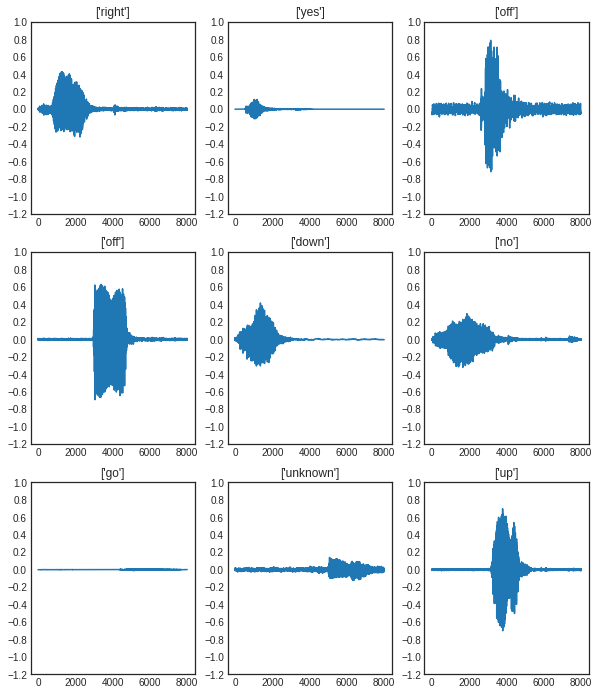

In [6]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(zip(audio_np[:9], label_np[:9])):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio)
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label
  ax.set_title(label)

plt.show()

In [7]:
sr = 16000

In [8]:
print(label_np[0]) 
ipd.Audio(audio_np[0], rate=sr)

['right']


In [9]:
print(label_np[45]) 
ipd.Audio(audio_np[45], rate=sr)

['up']


In [10]:
print(label_np[100]) 
ipd.Audio(audio_np[100], rate=sr)

['silence']


In [11]:
print(label_np[150]) 
ipd.Audio(audio_np[150], rate=sr)

['off']


In [12]:
print(label_np[200]) 
ipd.Audio(audio_np[200], rate=sr)

['go']


In [13]:
print(label_np[-1]) 
ipd.Audio(audio_np[-1], rate=sr)

['silence']


In [14]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

temp = []
for v in label_np.reshape(-1):
    temp.append(label_value[v])
label_np = np.array(temp)

label_np

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


array([ 5,  0,  7, ..., 10,  3, 11])

## 문제1. 데이터 전처리 : Mel-Spectrogram으로 변환하기



* 데이터를 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환하세요.

In [15]:
# 샘플레이트 출력
sr

16000

In [16]:
# MFCC 변환
audio_mfcc = []
for y in audio_np:
  ret = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=32,  hop_length=256)
  audio_mfcc.append(ret)

In [17]:
# 데이터 형변환
mfcc_np = np.array(audio_mfcc, np.float32)
label_np = np.array(label_np, np.float32)

print(mfcc_np.shape, label_np.shape)

(30000, 32, 32) (30000,)


- 변환한 MFCC를 시각화하세요. 

In [ ]:
for i in range(0, 5):
    ###########
    amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
    ###########

    librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')

    plt.title(f'Word : {label_np[i]}')
    plt.colorbar(format='%+2.0f dB')
    plt.xticks(range(0, 1))
    plt.tight_layout()
    plt.show()

### 2.MFCC를 이용한 머신러닝 오디오 분류



*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환하세요



In [ ]:
mfcc_np_ML = mfcc_np.reshape((10000, -1))
mfcc_np_ML.shape

- 오디오를 MinMaxScaler를 활용하여 스케일링 하세요
    *   읽어온 데이터는 음량이나 범위가 다를 수 있음
    *   min-max scaling을 통해 데이터의 범위를 조정함



In [ ]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
scaler.fit_transform(mfcc_np_ML)

* 학습 데이터와 실험 데이터를 분리하세요

In [ ]:
from sklearn.model_selection import train_test_split 

train_x, test_x, train_y, test_y = train_test_split(mfcc_np_ML, label_np, test_size = 0.2)


print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

- Decision Tree를 활용하여 각 오디오파일을 키워드 별로 분류하는 모델을 만드세요. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)

pred = DT.predict(test_x) 
acc = accuracy_score(pred, test_y)

print(acc)

- 원하는 머신러닝 분류모델 하나를 선택, 활용하여 각 오디오파일을 키워드 별로 분류하는 모델을 만드세요. 

In [ ]:
from sklearn import svm 

SVM = svm.SVC()

SVM.fit(train_x, train_y)

pred = SVM.predict(test_x)

acc = accuracy_score(pred, test_y)

print(acc)

### MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요합니다. 
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성됩니다. 
* 이 spectrogram을 CNN 이미지 분류를 통해 각 소리가 어떤 키워드인지 분류하세요

- 라벨링을 onehot vector로 변환하여, train과 test데이터를 분리하세요

In [20]:
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split 


mfcc_np_NN = np.array(audio_mfcc, np.float32)
mel_array_NN =  np.expand_dims(mfcc_np_NN, -1)# 채널 차원 추가
label_cat = to_categorical(label_np) # one hot vector로 변환

train_x, test_x, train_y, test_y = train_test_split(mel_array_NN, label_cat, test_size = 0.2) # 데이터 셋 분리 


print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(24000, 32, 32, 1)
(6000, 32, 32, 1)
(24000, 12)
(6000, 12)


*   spectrogram을 분류할 CNN 모델 구성하세요
    *   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
    *   spectrogram은 1차원 이미지로 간주


In [21]:
train_x = tf.repeat(train_x, 3, axis=3)
test_x = tf.repeat(test_x, 3, axis=3)

In [22]:

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(24000, 32, 32, 3)
(6000, 32, 32, 3)
(24000, 12)
(6000, 12)


In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(include_top=False, input_shape = (32, 32, 3), weights = 'imagenet')

# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = 'accuracy')

In [37]:
base_model.output_shape

(None, 1, 1, 2048)

In [38]:
base_model.trainable = True

In [39]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [40]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [41]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3084      
                                                                 
Total params: 24,115,340
Trainable params: 24,062,220
Non-t

In [42]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])


In [43]:
history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y),
                    epochs = 50, batch_size=64)

Epoch 1/50
375/375 [==============================] - 25s 51ms/step - loss: 2.4351 - accuracy: 0.1342 - val_loss: 2.2140 - val_accuracy: 0.1738
Epoch 2/50
375/375 [==============================] - 18s 49ms/step - loss: 1.9350 - accuracy: 0.2653 - val_loss: 1.6687 - val_accuracy: 0.3587
Epoch 3/50
375/375 [==============================] - 18s 48ms/step - loss: 1.6292 - accuracy: 0.3719 - val_loss: 1.4391 - val_accuracy: 0.4532
Epoch 4/50
375/375 [==============================] - 18s 48ms/step - loss: 1.2771 - accuracy: 0.5085 - val_loss: 1.0207 - val_accuracy: 0.5882
Epoch 5/50
375/375 [==============================] - 18s 48ms/step - loss: 1.0071 - accuracy: 0.6270 - val_loss: 0.9777 - val_accuracy: 0.6263
Epoch 6/50
375/375 [==============================] - 18s 48ms/step - loss: 0.8615 - accuracy: 0.6892 - val_loss: 0.8459 - val_accuracy: 0.6867
Epoch 7/50
375/375 [==============================] - 18s 48ms/step - loss: 0.7896 - accuracy: 0.7252 - val_loss: 0.7680 - val_accuracy:

In [44]:
def plot_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss)+1)
    fig = plt.figure(figsize=(14, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b--', label = 'train_loss')
    ax1.plot(epochs, val_loss, 'r--', label = 'val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, acc, 'b--', label = 'train_acc')
    ax2.plot(epochs, val_acc, 'r--', label = 'val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

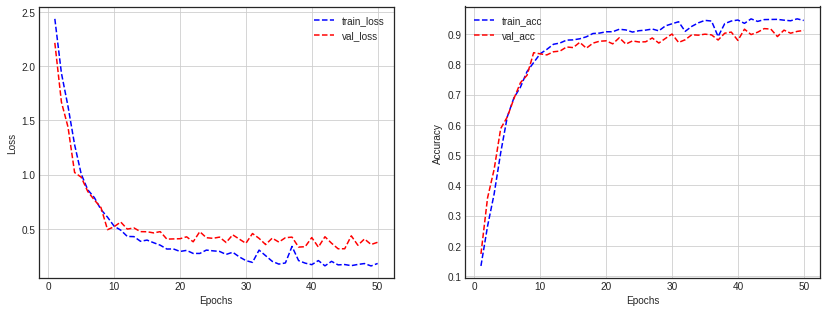

In [45]:
plot_history(history.history)

In [53]:
result = model.evaluate(test_x, test_y)

print('loss : {:0.3}'.format(result[0]))
print('acc : {:0.3}'.format(result[-1]))

188/188 [==============================] - 3s 14ms/step - loss: 0.3785 - accuracy: 0.9122
loss : 0.378
acc : 0.912
